In [136]:
!pip install -U tensorflow_datasets

In [137]:
import tensorflow as tf

In [138]:
import tensorflow_datasets as tfds

In [139]:
tfds.disable_progress_bar()

In [140]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [141]:
import logging

In [142]:
logger=tf.get_logger()
logger.setLevel(logging.ERROR)

# Import the Fashion MNIST dataset

In [143]:
dataset,metadata=tfds.load('fashion_mnist',as_supervised=True,with_info=True)
train_dataset,test_dataset=dataset['train'],dataset['test']

In [144]:
class_names=metadata.features['label'].names
print("Class names:{}".format(class_names))

Class names:['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [145]:
num_train_examples=metadata.splits['train'].num_examples
num_test_examples=metadata.splits['test'].num_examples
print("Number of training examples:{}".format(num_train_examples))
print("Number of test examples:{}".format(num_test_examples))

Number of training examples:60000
Number of test examples:10000


# Preprocess the data

The value of each pixel in the image data is an integer in the range **[0,255]**. For the model to work properly, these values need to be normalized to the range **[0,1]**. So here we create a normalization function, and then apply it to each image in the test and train datasets.


In [146]:
def normalize(images, labels):
  images= tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()
# The map function applies the normalize function to each element in the train
# and test datasets   
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

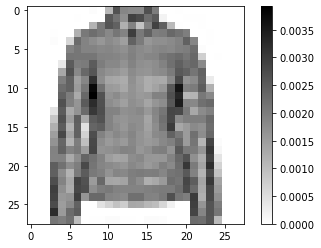

In [147]:
# Take a single image, and remove the color dimension by reshaping
for image,label in test_dataset.take(1):
    break
image=image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image,cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

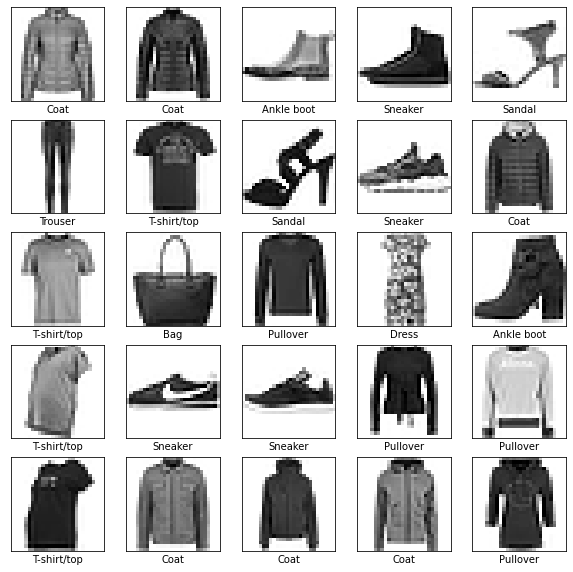

In [148]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(test_dataset.take(25)):
    image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image,cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [149]:
model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax)    
])

This network has three layers:

**input** tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28 × 28 pixels, to a 1d-array of 784 pixels (28*28). 

**hidden** tf.keras.layers.Dense— A densely connected layer of **512 neurons.** Each neuron (or node) takes input from all **784 nodes** in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

**output** tf.keras.layers.Dense* — A 128-neuron, followed by **10-node softmax layer**. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the **512 nodes** in the layer before it, and outputs a value in the range **[0, 1]**, representing the probability that the image belongs to that class. The sum of all **10 node values is 1**.

# Compile the model
**Loss Function**= An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.

**Optimizer**= An algorithm for adjusting the inner parameters of the model in order to minimize loss.

**Metrics**=Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [150]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

# Train the model
- Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
- The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples
- dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the model.fit method:
- Feed the training data to the model using train_dataset.
- The model learns to associate images and labels.
- The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [151]:
BATCH_SIZE=32
train_dataset=train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset=test_dataset.cache().batch(BATCH_SIZE)

model.fit(train_dataset,epochs=5,steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6895 - accuracy: 0.7479
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4595 - accuracy: 0.8336
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4101 - accuracy: 0.8491
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3778 - accuracy: 0.8622
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3543 - accuracy: 0.8699


### Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [152]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3782 - accuracy: 0.8648
Accuracy on test dataset: 0.864799976348877


## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [153]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
    
predictions.shape

(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [154]:
predictions[0]

array([2.71740020e-04, 2.75032362e-04, 3.87871973e-02, 1.19819983e-04,
       8.42765689e-01, 2.10504804e-05, 1.16377234e-01, 1.09017453e-08,
       1.38149376e-03, 7.23733478e-07], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [155]:
np.argmax(predictions[0])

4

In [156]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [157]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

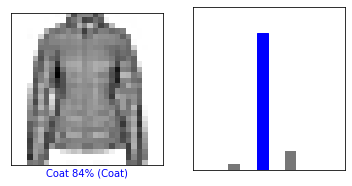

In [158]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

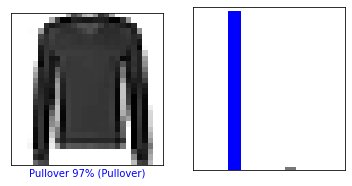

In [159]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

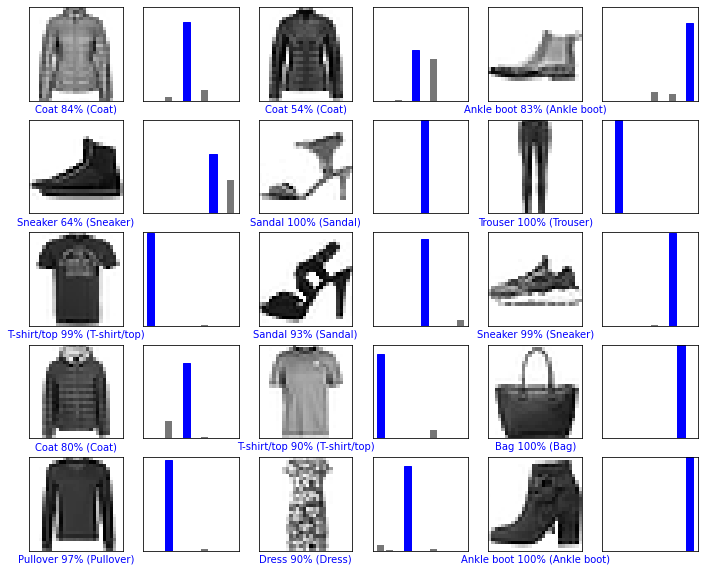

In [160]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image. 

In [161]:
img = test_images[0]

print(img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [162]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [163]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.7173976e-04 2.7503236e-04 3.8787205e-02 1.1981987e-04 8.4276569e-01
  2.1050520e-05 1.1637721e-01 1.0901766e-08 1.3814938e-03 7.2373626e-07]]


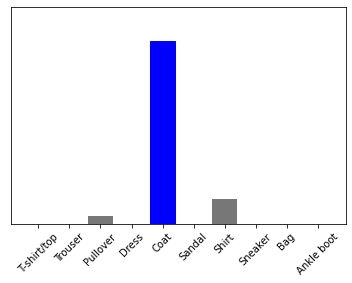

In [164]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [165]:
np.argmax(predictions_single[0])

4